problem --> predictive model --> action --> decision making

predictive modelling : case --> vad kan det appliceras på -->

predictive model --> prediktera denna individ till att hen har bytt eller inte.

** Hur kan vi få prediktera en individ till att vara churn eller inte  ** - mycket krut här bara


DEPLOYMENT, you neeed to monitor it also!!!!!!

PLEAASE MAKE A KPI  ---> Analytics called metric

Jupyter is actually supported by Google Datalabs, som bara finns i USA.

http://vision-explorer.reactive.ai/



# Hands on example of making predictive models

# Customer Churn

"Churn Rate" - measure of the number of individuals or items moing out of a collective group over a specific period of time. - Wikipedia

<img src="https://www.statuscake.com/wp-content/uploads/2016/02/Customer-Churn.jpg" style="width:70%" />

Churn (loss of customers to competition) is a problem for any company because it is more expensive to acquire a new customer than to keep your existing one from leaving. This example we will examine the churn for telecom companies.

## Binary Classification

More on [classification](data-mining-intro-ML-may-2016.ipynb) in the machine learning intro notebook.


This labeling schema is arguably the most common classification schema which is called binary classification as I have only two classes to predict(churn or not). Even some of the multi-class classification problems could be expressed as a binary classification schema(one vs other classes). 

<img src="http://www.holehouse.org/mlclass/06_Logistic_Regression_files/Image%20[23].png" style="width:70%"/>

Therefore, it is a powerful/basic classification schema that you would use approximately 83%(put some random number > 50) of your machine learning problems.

## Imports

In [2]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
%matplotlib inline

## Preparing data

Loading data from csv

In [3]:
churn_df = pd.read_csv('../data/raw/churn.csv')
col_names = churn_df.columns.tolist()

print("Columns names:",col_names)

print("\n Sample data:")
to_show = col_names[:6] + col_names[-6:]
churn_df[to_show].head(6)

Columns names: ['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']

 Sample data:


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,11.01,10.0,3.0,2.70,1.0,False.
1,OH,107,415,371-7191,no,yes,11.45,13.7,3.0,3.70,1.0,False.
2,NJ,137,415,358-1921,no,no,7.32,12.2,5.0,3.29,0.0,False.
3,OH,84,408,375-9999,yes,no,8.86,6.6,7.0,1.78,2.0,False.
4,OK,75,415,330-6626,yes,no,8.41,10.1,3.0,2.73,3.0,False.
5,AL,118,510,391-8027,yes,no,9.18,6.3,6.0,1.70,0.0,False.


In [4]:
# Isolate target data
churn_result = churn_df['Churn?']
y = np.where(churn_result == 'True.',1,0)

# remove some columns, we might need them 
# but this is just for example purpose
to_drop = ['State', 'Area Code', 'Phone', 'Churn?']
churn_feat_space = churn_df.drop(to_drop, axis=1)

# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
yes_no_cols = ["Int'l Plan","VMail Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

Why are we removing the **Churn?** - column?
- answer : it is already saved in the **y** variable (target variable)

### Creating the training data
Many predictors care about the relative size of different features even though those scales might be arbitrary. For instance: the number of points a basketball team scores per game will naturally be a couple orders of magnitude larger than their win percentage. But this doesn't mean that the latter is 100 times less signifigant. StandardScaler fixes this by normalizing each feature to a range of around 1.0 to -1.0 thereby preventing models from misbehaving. Well, at least for that reason.

Great, I now have a feature space X and a set of target values y. On to the predictions!

In [5]:
churn_feat_space = churn_feat_space.fillna(0)
X = churn_feat_space.as_matrix().astype(np.float)

# This is important
scaler = StandardScaler()
X = scaler.fit_transform(X)
print("Feature space holds %d observations and %d features" % X.shape)
print("Unique target labels:", np.unique(y))

Feature space holds 3333 observations and 17 features
Unique target labels: [0 1]


### Simple classifier
**ALWAYS** start **SIMPLE.**

Here we make support vector machine classifer to begin with.

In [6]:
# clf stands for classifier and SVC stands for support vector machine
clf = SVC(kernel='rbf')
clf = clf.fit(X,y)
print("Score",clf.score(X,y))

Score 0.949894989499


## Model the domain, but how good is your model?
Express, test, cycle. A machine learning pipeline should be anything but static. There are always new features to design, new data to use, new classifiers to consider each with unique parameters to tune. And for every change it's critical to be able to ask, "Is the new version better than the last?" So how do I do that?

As a good start, cross validation will be used throught this example. Cross validation attempts to avoid overfitting (training on and predicting the same datapoint) while still producing a prediction for each observation dataset. This is accomplished by systematically hiding different subsets of the data while training a set of models. After training, each model predicts on the subset that had been hidden to it, emulating multiple train-test splits. When done correctly, every observation will have a 'fair' corresponding prediction.

Here's what that looks like using scikit-learn libraries.

### Cross Validation
Pretty much tries to fit model parameters for the data at hand

In [7]:
from sklearn.cross_validation import KFold

def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=3,shuffle=True)
    y_pred = y.copy()
    
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

Let's compare three fairly unique algorithms support vector machines, random forest, and k-nearest-neighbors. Nothing fancy here, just passing each to cross validation and determining how often the classifier predicted the correct class.

* **Support Vector Machines**
* **Random Forest**
* **K-nearest-neighbors**

In [8]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import average_precision_score

def accuracy(y_true,y_pred):
    # NumPy interpretes True and False as 1. and 0.
    return np.mean(y_true == y_pred)

print("Accuracy",)
print("Logistic Regression:")
print("%.3f" % accuracy(y, run_cv(X,y,LR)))
print("Gradient Boosting Classifier")
print("%.3f" % accuracy(y, run_cv(X,y,GBC)))
print("Support vector machines:")
print("%.3f" % accuracy(y, run_cv(X,y,SVC)))
print("Random forest:")
print("%.3f" % accuracy(y, run_cv(X,y,RF)))
print("K-nearest-neighbors:")
print("%.3f" % accuracy(y, run_cv(X,y,KNN)))

Accuracy
Logistic Regression:
0.861
Gradient Boosting Classifier
0.952
Support vector machines:
0.917
Random forest:
0.941
K-nearest-neighbors:
0.893



**Random forest** won, right?

## Precision and recall 

Measurements aren't golden formulas which always spit out high numbers for good models and low numbers for bad ones. Inherently they convey something sentiment about a model's performance, and it's the job of the human designer to determine each number's validity. The problem with accuracy is that outcomes aren't necessarily equal. If my classifier predicted a customer would churn and they didn't, that's not the best but it's forgivable. However, if my classifier predicted a customer would return, I didn't act, and then they churned... that's really bad.

We'll be using another built in `scikit-learn` function to construction a confusion matrix. A confusion matrix is a way of visualizing predictions made by a classifier and is just a table showing the distribution of predictions for a specific class. The x-axis indicates the true class of each observation (if a customer churned or not) while the y-axis corresponds to the class predicted by the model (if my classifier said a customer would churned or not).

## Confusion matrix and confusion tables: 
The columns represent the actual class and the rows represent the predicted class. Lets evaluate performance: 

|      | Condition True | Condition False|
|------|----------------|---------------|
|**Prediction True**|True Positive|False positive|
|**Prediction False**|False Negative|True Negative|

Sensitivity, Recall or True Positive Rate quantify the models ability to predict our positive classes. 

$$TPR = \frac{ TP}{TP + FN}$$ 

Specificity or True Negative Rate quantify the models ability to predict our Negative classes. 

$$TNR = \frac{ TN}{FP + TN}$$ 

### Example:

|      | Spam | Ham|
|------|----------------|---------------|
|prediction Spam|100|50|
|Prediction Ham|75|900|

$$TPR = \frac{100}{100 + 75} = 57.14 \%   Sensitive $$

$$TNR = \frac{ 900}{50 + 900} = 94.73 \% Specific $$



In [9]:
from sklearn import metrics
grad_ens_conf_matrix = metrics.confusion_matrix(y, run_cv(X, y, GBC))
svm_svc_conf_matrix = metrics.confusion_matrix(y, run_cv(X, y, SVC))
random_forest_conf_matrix = metrics.confusion_matrix(y, run_cv(X, y, RF))
k_neighbors_conf_matrix = metrics.confusion_matrix(y, run_cv(X, y, KNN))
logistic_reg_conf_matrix = metrics.confusion_matrix(y, run_cv(X, y, LR))
dumb_conf_matrix = metrics.confusion_matrix(y, [0 for ii in y.tolist()]); # ignore the warning as they are all 0

conf_matrix = {
                1: {
                    'matrix': grad_ens_conf_matrix,
                    'title': 'Gradient Boosting',
                   },
                2: {
                    'matrix': svm_svc_conf_matrix,
                    'title': 'Support Vector Machine',
                   },
                3: {
                    'matrix': random_forest_conf_matrix,
                    'title': 'Random Forest',
                   },
                4: {
                    'matrix': k_neighbors_conf_matrix,
                    'title': 'K Nearest Neighbors',
                   },
                5: {
                    'matrix': logistic_reg_conf_matrix,
                    'title': 'Logistic Regression',
                   },
                6: {
                    'matrix': dumb_conf_matrix,
                    'title': 'Dumb',
                   },
}

In [10]:
import seaborn as sns
plt.style.use('fivethirtyeight') # Good looking plots

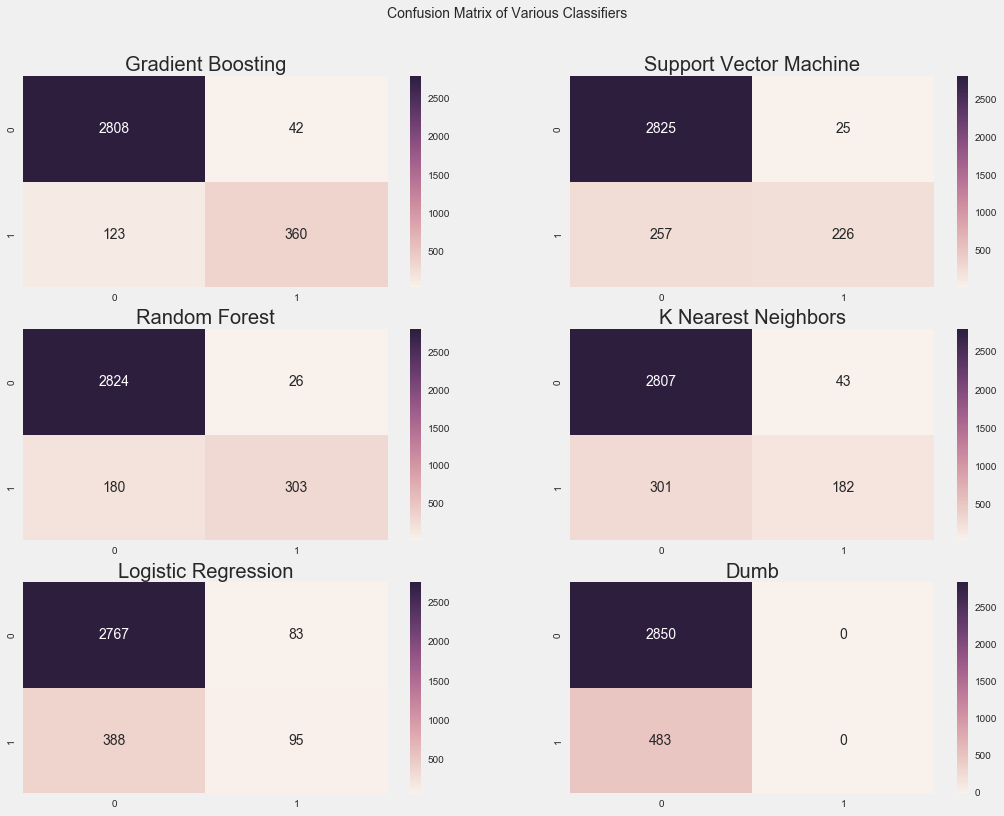

In [11]:
fix, ax = plt.subplots(figsize=(16, 12))
plt.suptitle('Confusion Matrix of Various Classifiers')
for ii, values in conf_matrix.items():
    matrix = values['matrix']
    title = values['title']
    plt.subplot(3, 2, ii) # starts from 1
    plt.title(title);
    sns.heatmap(matrix, annot=True,  fmt='');

It calls for action
Predictive analytics unlike other analytics is made for action

# Visualizing via a Decision Tree to explore the features!!

In [12]:
from __future__ import print_function

import os
import subprocess

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [13]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [14]:
visualize_tree(clf,churn_feat_space.columns)

AttributeError: 'SVC' object has no attribute 'tree_'